# Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Installing the necessary libraries

In [ ]:
!pip install keras
!pip install matplotlib
!pip install pandas
!pip install scikit-learn
!pip install seaborn

# Import necessary libraries

In [ ]:
import os
from google.colab import drive
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import plot_model
import seaborn as sns
import time
import random
import shutil
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define Directory path

In [ ]:
data_dir = '/content/gdrive/MyDrive/Colab Notebooks/skin_disease_dataset'
test_data_dir = '/content/gdrive/MyDrive/Colab Notebooks/skin_disease_dataset/main_dataset_test'

# Load and preprocess image data & Data Augmentation

In [ ]:
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1 / 255,
                                validation_split=0.2,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=20,
                               ).flow_from_directory(directory= data_dir,
                                                     target_size=(380, 380),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.2,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(380, 380),
                                                     subset='validation',
                                                    ),

    "test" : ImageDataGenerator(rescale=1 / 255,).flow_from_directory(
                                directory=test_data_dir,
                                target_size=(380, 380),
                                shuffle=False,
),
}


Found 1483 images belonging to 8 classes.
Found 366 images belonging to 8 classes.
Found 465 images belonging to 8 classes.


# Seperating Training and Testing Data & Setting variables

In [ ]:
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]
test_generator = datagenerator["test"]

batch_size = 32

# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 46
validation_steps : 11


# Model architecture

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(380, 380, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(8, activation='softmax') # 8 classes
])

# Compile the model

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler

In [ ]:
def lr_scheduler(epoch):
    return 0.001 * (0.1 ** (epoch // 10))

learning_rate_scheduler = LearningRateScheduler(lr_scheduler)

# Early Stopping

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Show model summary & plot

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 128)      

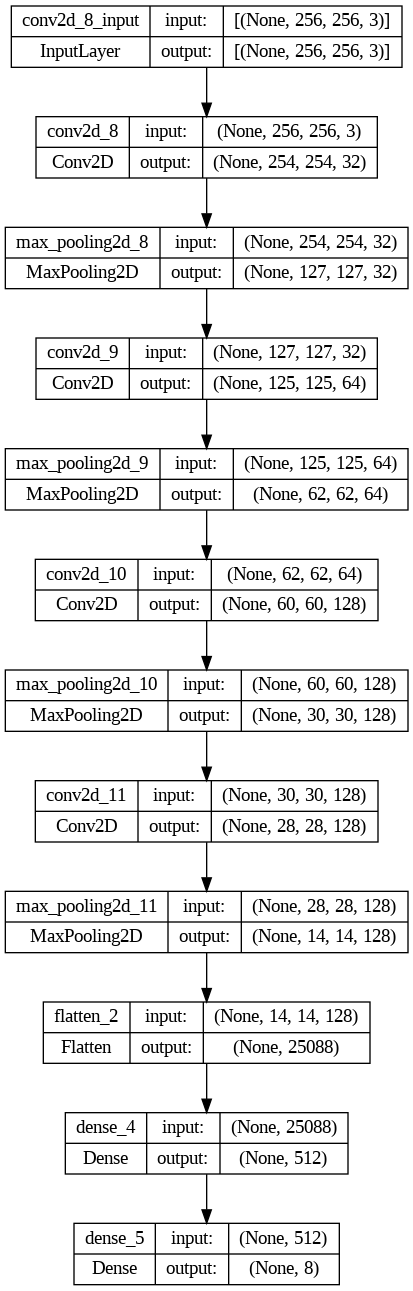

In [ ]:
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

# Model Checkpointing

In [ ]:
checkpoint_path = "/content/gdrive/MyDrive/Colab Notebooks/skin_disease_dataset/main_dataset/best_model_main_dataset.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model with callbacks

In [ ]:
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs = 30,
    validation_data=valid_generator ,
    validation_steps=valid_generator .samples // valid_generator.batch_size,
    verbose=1,
    callbacks=[learning_rate_scheduler, early_stopping, model_checkpoint]
)
end_time = time.time()

Epoch 1/5
46/46 [==============================] - ETA: 0s - loss: 2.0130 - accuracy: 0.1826
Epoch 1: val_accuracy improved from -inf to 0.22443, saving model to /content/gdrive/MyDrive/Colab Notebooks/skin_disease_dataset/main_dataset/best_model_main_dataset.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 533s 11s/step - loss: 2.0130 - accuracy: 0.1826 - val_loss: 1.8983 - val_accuracy: 0.2244 - lr: 0.0010
Epoch 2/5
46/46 [==============================] - ETA: 0s - loss: 1.7306 - accuracy: 0.3184
Epoch 2: val_accuracy did not improve from 0.22443
46/46 [==============================] - 292s 6s/step - loss: 1.7306 - accuracy: 0.3184 - val_loss: 2.0597 - val_accuracy: 0.2017 - lr: 0.0010
Epoch 3/5
46/46 [==============================] - ETA: 0s - loss: 1.6815 - accuracy: 0.3460
Epoch 3: val_accuracy did not improve from 0.22443
46/46 [==============================] - 286s 6s/step - loss: 1.6815 - accuracy: 0.3460 - val_loss: 1.9112 - val_accuracy: 0.2045 - lr: 0.0010
Epoch 4/5
46/46 [==============================] - ETA: 0s - loss: 1.5714 - accuracy: 0.3970
Epoch 4: val_accuracy improved from 0.22443 to 0.42898, saving model to /content/gdrive/MyDrive/Colab Notebooks/skin_disease_dataset/main_dataset/best_model_main_dataset.h5
46/46 [=========

# Total time & per epoch time calculation

In [ ]:
total_time = (end_time - start_time)/60
time_per_epoch = total_time / 50  # number of epochs

print(f"Time per epoch: {time_per_epoch} minutes")
print(f"Total time for training: {total_time} minutes")

Time per epoch: 6.014649261633555 minutes
Total time for training: 30.073246308167775 minutes


# Save predictions of test data to a CSV file

In [ ]:
test_predictions = model.predict(test_generator)
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

results_df = pd.DataFrame({'Actual Label': [class_labels[i] for i in true_labels],
                           'Predicted Label': [class_labels[i] for i in predicted_labels]})
results_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/skin_disease_dataset/main_dataset/test_predictions.csv', index=False)

15/15 [==============================] - 146s 10s/step


# Evaluate the model on test set

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy}')

15/15 [==============================] - 27s 2s/step - loss: 1.7994 - accuracy: 0.3269
Test Accuracy: 0.3268817067146301


# Plot training history

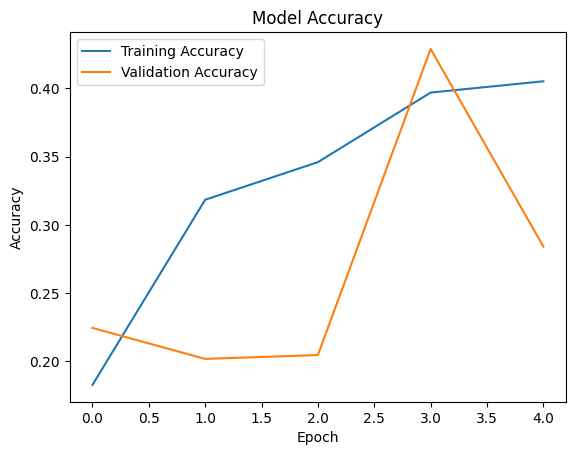

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate precision, recall, f1-score

In [ ]:
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: [0.28571429 0.53333333 0.27807487 0.         0.42222222 0.53333333
 0.         0.328     ]
Recall: [0.25806452 0.13333333 0.75362319 0.         0.35185185 0.27586207
 0.         0.82      ]
F1-score: [0.27118644 0.21333333 0.40625    0.         0.38383838 0.36363636
 0.         0.46857143]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Calculate weighted precision, recall, f1-score

In [ ]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Precision (Weighted):", precision)
print("Recall (Weighted):", recall)
print("F1-score (Weighted):", f1)

Precision (Weighted): 0.2989995372538067
Recall (Weighted): 0.32688172043010755
F1-score (Weighted): 0.26428293025545624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Plot confusion matrix

In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[16  1 36  0  1  0  2  6]
 [ 4  8 19  0  0  1  0 28]
 [ 5  0 52  0  9  0  0  3]
 [ 8  1 13  0  2  5  2 16]
 [ 3  0 20  0 19  6  0  6]
 [ 1  1 14  0 14 16  3  9]
 [14  4 30  0  0  1  0 16]
 [ 5  0  3  0  0  1  0 41]]


# Plot model accuracy

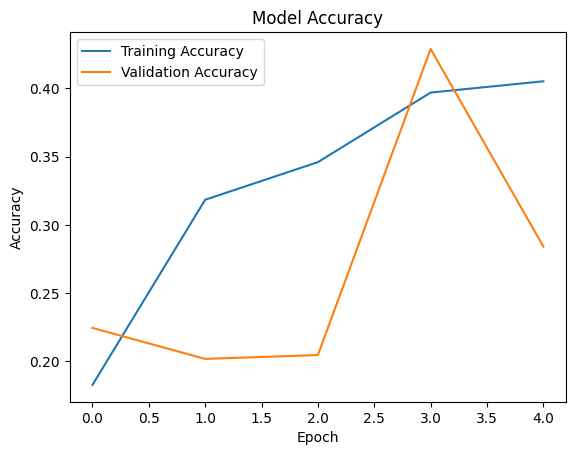

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot model loss

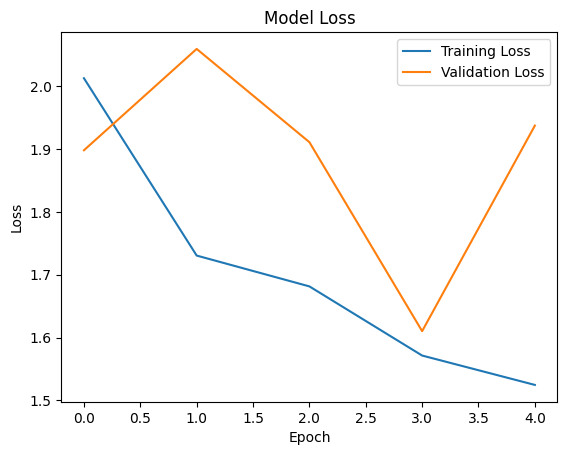

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Count the number of occurrences of each predicted label

In [ ]:
predicted_label_counts = pd.Series(predicted_labels).value_counts()

# Create a DataFrame to store the predicted label counts

In [ ]:
predicted_label_counts_df = pd.DataFrame({

    'Count': predicted_label_counts.values
})
# Map numerical labels to class names
class_names = [class_labels[i] for i in predicted_label_counts.index]

# Create DataFrame with class names
predicted_label_counts_df['Class'] = class_names

# Plot the distribution of predicted labels using Seaborn

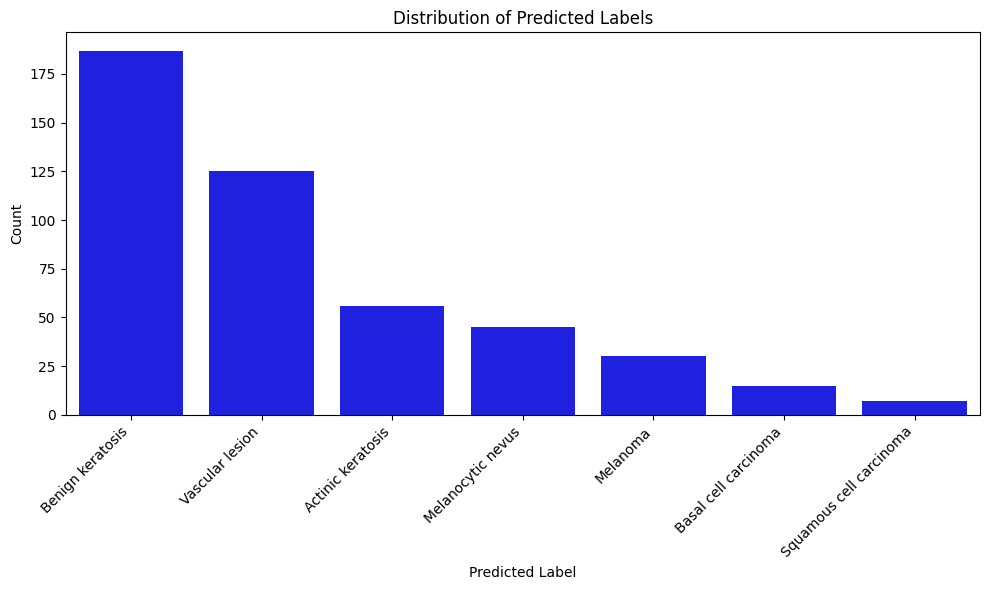

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=predicted_label_counts_df, x='Class', y='Count', color='blue')
plt.title('Distribution of Predicted Labels')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(results_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
